In [1]:
import requests
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [72]:

base_url = "http://fits.geonet.org.nz/"
endpoint = "observation"

url = base_url + endpoint
parameters ={"typeID": "e", "siteID": "MAHI"}

response_e = requests.get(url, params=parameters)
parameters["typeID"] = "n"
response_n = requests.get(url, params=parameters)
parameters["typeID"] = "u"
response_u = requests.get(url, params=parameters)

In [73]:
def GNSS_dataframe(data):
    """
    This function turns the string of GNSS data received by requests.get
    into a data frame with GNSS data correctly formatted.
    """
    data = data.split("\n") # splits data on the new line symbol
    for i in range(0, len(data)):
        data[i]= data[i].split(",")# splits data ponits on the , symbol
    for i in range(1, (len(data)-1)):
        data[i][0] = datetime.datetime.strptime(data[i][0], '%Y-%m-%dT%H:%M:%S.%fZ') #make 1st value into a datetime object
        data[i][1] = float(data[i][1]) #makes 2nd value into a decimal number
        data[i][2] = float(data[i][2]) #makes 3rd value into a decimal number
    df = pd.DataFrame(data[1:-1],index = range(1, (len(data)-1)), columns=data[0]) #make the list into a data frame
    return df

In [74]:
df_e = GNSS_dataframe(response_e.content.decode("utf-8"))
df_u = GNSS_dataframe(response_u.content.decode("utf-8"))
df_n = GNSS_dataframe(response_n.content.decode("utf-8"))

                              
df_e = df_e.set_index('date-time')
df_u = df_u.set_index('date-time')
df_n = df_n.set_index('date-time')

df_e.columns = ['e', 'error']
df_u.columns = ['u', 'error']
df_n.columns = ['n', 'error']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efe3b9f6518>],
      dtype=object)

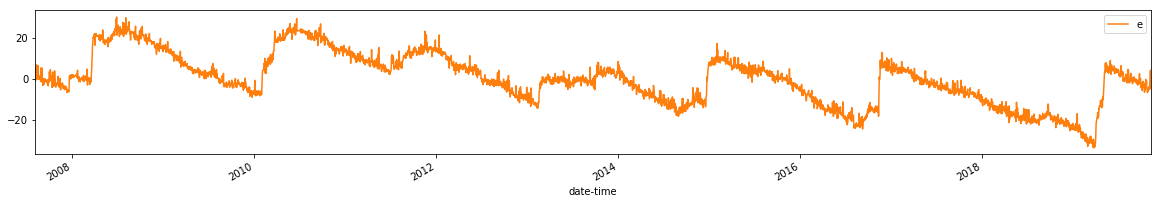

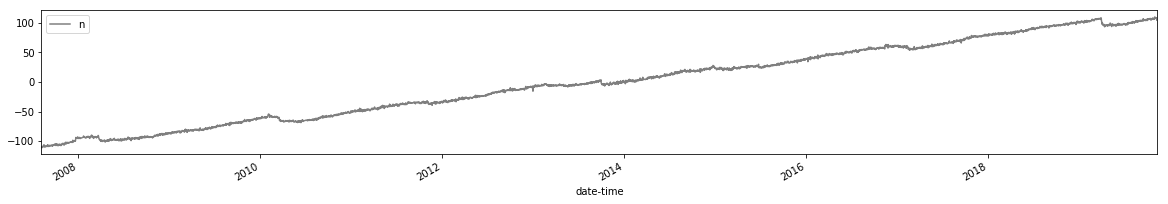

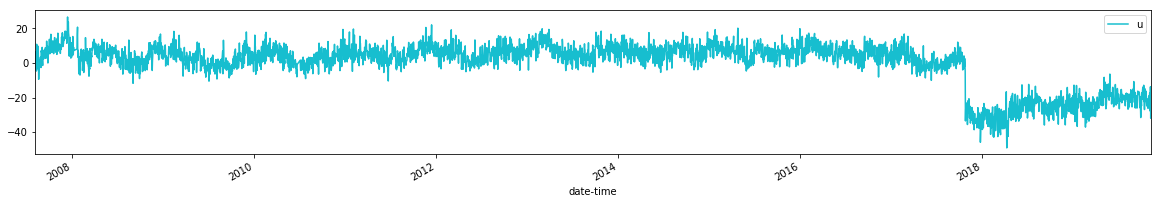

In [75]:
df_e.plot(y=["e"],figsize=(20,10),subplots=True, layout=(3,1),color='tab:orange')
df_n.plot(y=["n"],figsize=(20,10),subplots=True, layout=(3,1),color='tab:gray')
df_u.plot(y=["u"],figsize=(20,10),subplots=True, layout=(3,1),color='tab:cyan')

In [76]:
df_e['gradient'] = df_e['e'].diff(periods=30) # discrete difference

In [77]:
df_e['smooth'] = df_e['gradient'].ewm(span = 30).mean()
df_e['rolling'] = df_e['gradient'].rolling(window=30).mean()

In [78]:
df_e.count()

e           4454
error       4454
gradient    4424
smooth      4424
rolling     4395
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efe315707f0>],
      dtype=object)

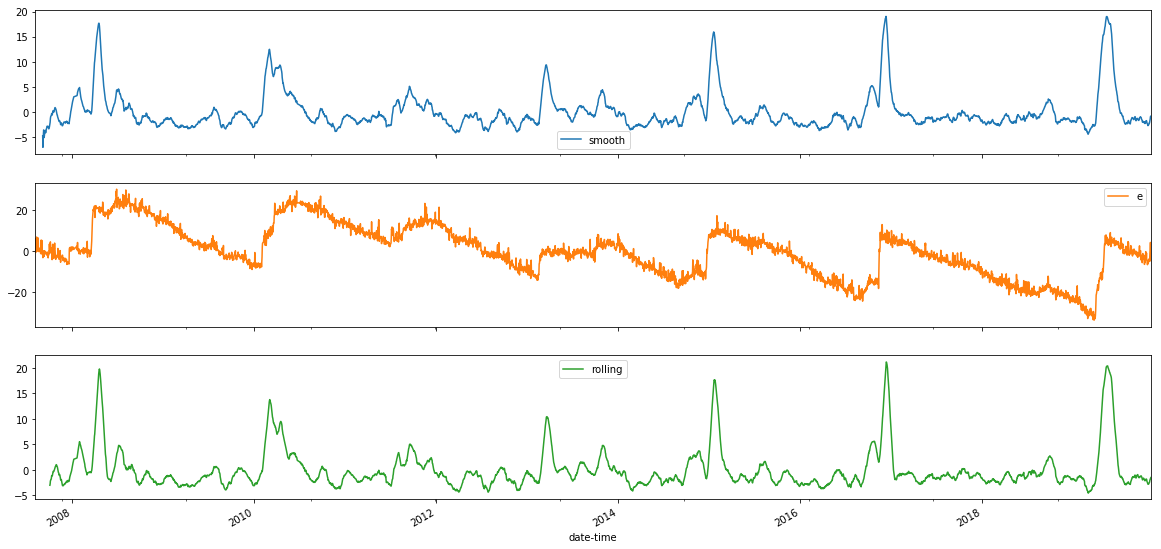

In [79]:
# df_e.plot(y=["gradient", "e","smooth"],figsize=(20,10))
# df_e.plot(y=["gradient","smooth","rolling","e"],figsize=(20,10))
df_e.plot(y=["smooth","e","rolling"],figsize=(20,10),subplots=True, layout=(3,1))

# Linear Regression Test 

In [80]:
from sklearn import linear_model

In [81]:
reg = linear_model.LinearRegression()

In [82]:
df_e['counter'] = range(len(df_e))
df_e.head()

,e,error,gradient,smooth,rolling,counter
date-time,,,,,,
2007-08-05 11:59:00,5.01,1.43,NaN,NaN,NaN,0
2007-08-06 11:59:00,5.95,1.43,NaN,NaN,NaN,1
2007-08-07 11:59:00,-0.69,1.40,NaN,NaN,NaN,2
2007-08-08 11:59:00,1.76,1.75,NaN,NaN,NaN,3
2007-08-09 11:59:00,0.60,1.84,NaN,NaN,NaN,4


In [83]:

counter = np.array(df_e['counter'].values.reshape(-1,1))
y_e = np.array(df_e['e'].values.reshape(-1))


# np.shape(y_e)
# reg.fit(df_e['e'].values.reshape(-1,1),df_e['counter'].values.reshape(-1,1))

In [84]:
reg.fit(counter,y_e)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [85]:
m=reg.coef_
b=reg.intercept_
print("slope=",m, "intercept=",b)

slope= [-0.00612022] intercept= 13.628719725317847


Text(0, 0.5, 'GNSS-displacement')

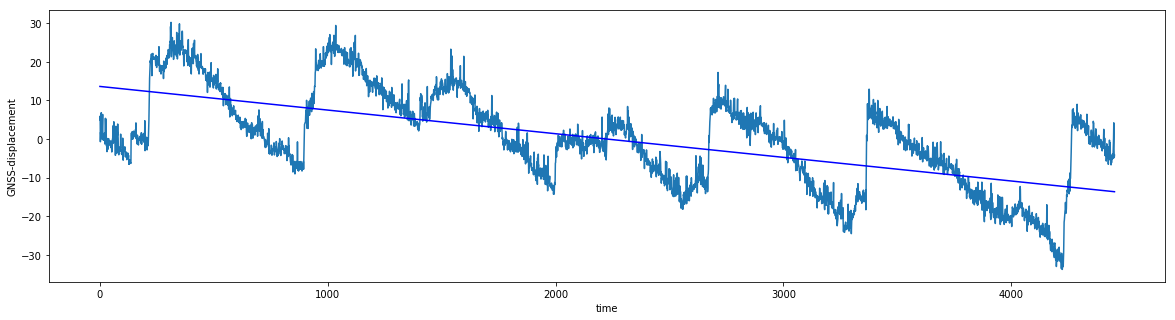

In [86]:
plt.figure(figsize=(20,5))
plt.plot(counter,y_e)
predicted_values = [m * i + b for i in (counter)]
plt.plot(counter, predicted_values, 'b')

plt.xlabel("time")
plt.ylabel("GNSS-displacement")

# Linear Regression Sliding windows

In [87]:
window = 35 # number of days

pendiente = []
ordenada =  []

for i in range(window,len(df_e)):
    
    temp = df_e.iloc[i-window:i,:]

    counter_temp = np.array(temp['counter'].values.reshape(-1,1))
    y_e_temp = np.array(temp['e'].values.reshape(-1))

    reg.fit(counter_temp,y_e_temp)
    
    m_temp = reg.coef_
    b_temp = reg.intercept_
    
    pendiente.append(m_temp)
    ordenada.append(b_temp)


In [88]:
df_predict = pd.DataFrame(pendiente,ordenada)
df_predict = df_predict.reset_index()

df_predict.columns = ['intercept','slope']

df_predict['slope'] = df_predict['slope']

df_predict['rolling'] = df_predict['slope'].rolling(window=35).mean()

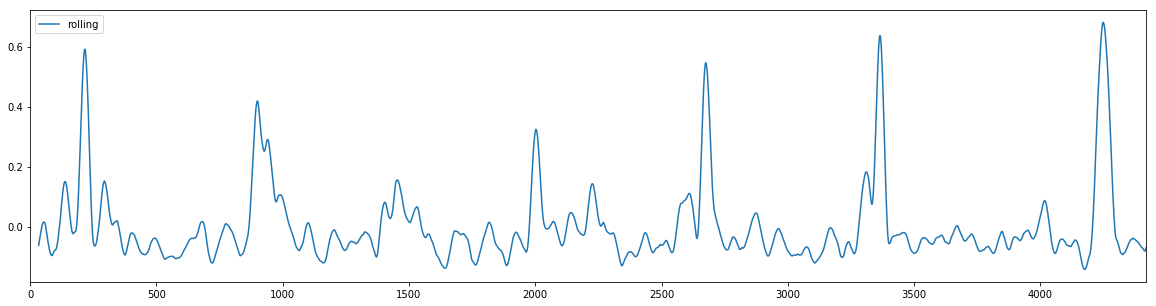

In [89]:
df_predict.plot(y=["rolling"],figsize=(20,5))
# df_e.plot(y=["e"],figsize=(20,10),subplots=False)

In [90]:
df_predict['counter'] = range(len(df_predict))

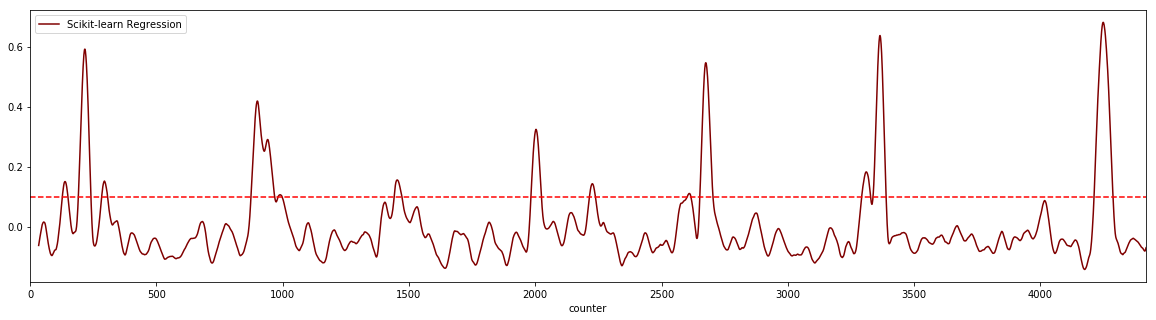

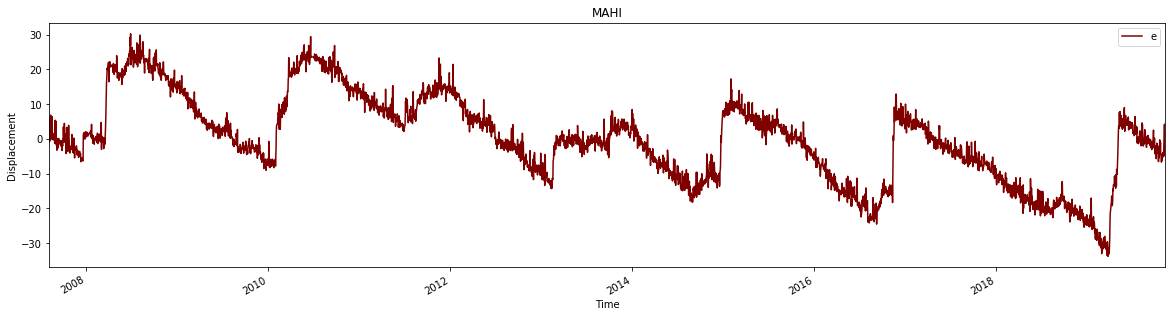

In [116]:
fig, ax = plt.subplots()
# ax2 = ax.twinx()

# df_e.plot(x="counter", y=["rolling"], ax=ax,figsize=(20,5))
# df_predict.plot(x="counter", y=["rolling"], ax=ax2, color='maroon',figsize=(20,5))

df_predict.plot(x="counter", y=["rolling"], ax=ax,color='maroon',figsize=(20,5))

plt.axhline(y=0.1, color='r', linestyle='--')

df_e.plot(y=["e"],figsize=(20,5),color='maroon')


plt.title("MAHI")
plt.ylabel("Displacement")
plt.xlabel("Time")

# ax.legend(["Rolling-mean"], loc='upper right')
ax.legend(["Scikit-learn Regression"])

plt.show()

# Three components

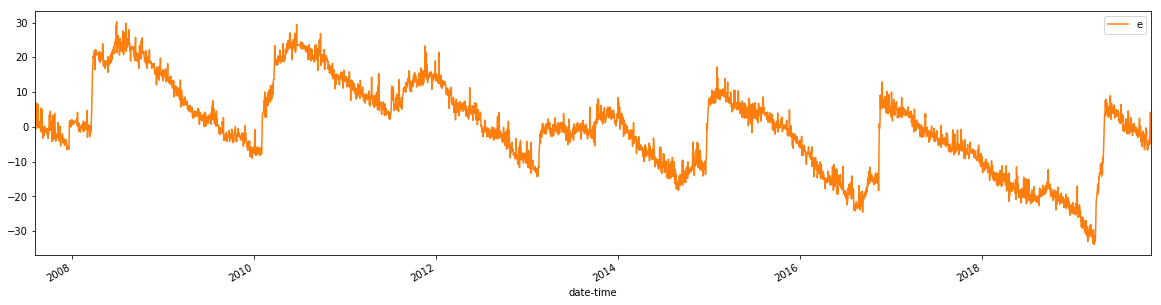

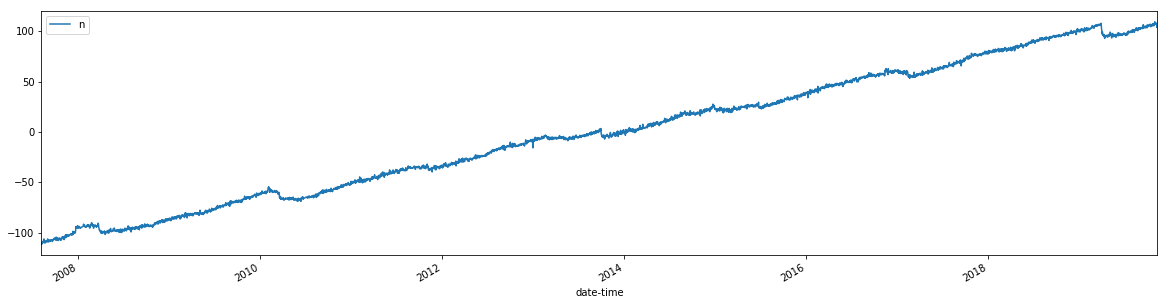

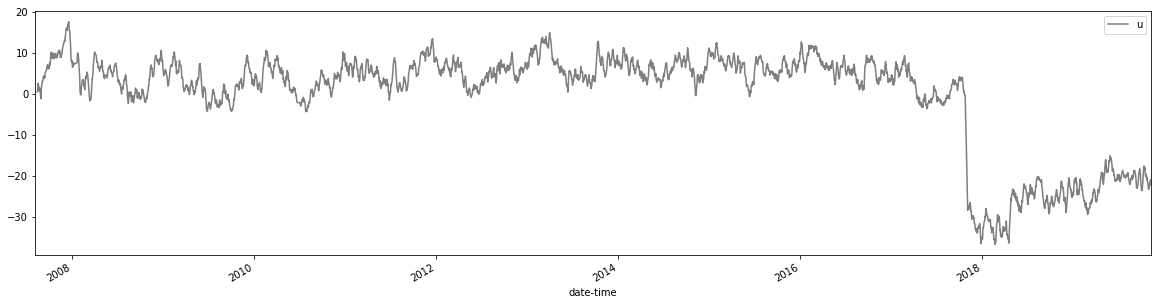

In [92]:
df_e.plot(y='e',figsize=(20,5),color='tab:orange')
df_n.plot(y='n',figsize=(20,5),label='n')
df_u['rolling'] = df_u['u'].rolling(window=10).mean()
df_u.plot(y='rolling',figsize=(20,5),label='u',color='tab:gray')


## Gradient in North component

In [125]:
df_n['counter'] = range(len(df_n))

In [126]:
window = 35 # number of days

pendiente = []
ordenada =  []

for i in range(window,len(df_e)):
    
    tempn = df_n.iloc[i-window:i,:]

    counter_tempn = np.array(tempn['counter'].values.reshape(-1,1))
    y_e_tempn = np.array(tempn['n'].values.reshape(-1))

    reg.fit(counter_tempn,y_e_tempn)
    
    m_tempn = reg.coef_
    b_tempn = reg.intercept_
    
    pendiente.append(m_tempn)
    ordenada.append(b_tempn)


In [127]:
df_predictn = pd.DataFrame(pendiente,ordenada)
df_predictn = df_predictn.reset_index()

df_predictn.columns = ['intercept','slope']

df_predictn['slope'] = df_predictn['slope']*-1.0

df_predictn['rolling'] = df_predictn['slope'].rolling(window=35).mean()

In [128]:
df_predictn['counter'] = range(len(df_predictn))

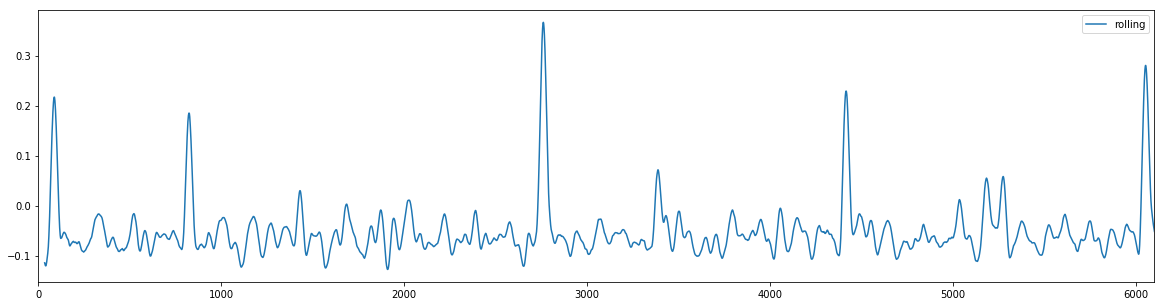

In [129]:
# df_n.plot(y='n',figsize=(20,5))
df_predictn.plot(y=['rolling'],figsize=(20,5))
# df_predict.plot( y=["rolling"], color='red',figsize=(20,5))

In [130]:
# df_predict.plot(x="counter", y=["rolling"], ax=ax2, color='red')

## Gradient in component u

In [131]:
df_u['counter'] = range(len(df_u))

In [132]:
window = 35 # number of days

pendienteu = []
ordenadau =  []

for i in range(window,len(df_u)):
    
    tempu = df_u.iloc[i-window:i,:]

    counter_tempu = np.array(tempu['counter'].values.reshape(-1,1))
    y_e_tempu = np.array(tempu['u'].values.reshape(-1))

    reg.fit(counter_tempu,y_e_tempu)
    
    m_tempu = reg.coef_
    b_tempu = reg.intercept_
    
    pendienteu.append(m_tempu)
    ordenadau.append(b_tempu)


In [133]:
df_predictu = pd.DataFrame(pendienteu,ordenadau)
df_predictu = df_predictu.reset_index()

df_predictu.columns = ['intercept','slope']

df_predictu['slope'] = df_predictu['slope']*-1.0

df_predictu['rolling'] = df_predictu['slope'].rolling(window=35).mean()

In [134]:
df_predictu['counter'] = range(len(df_predictu))

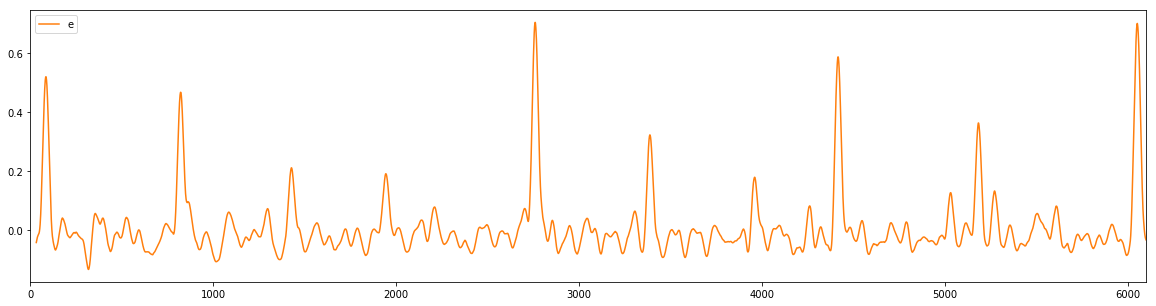

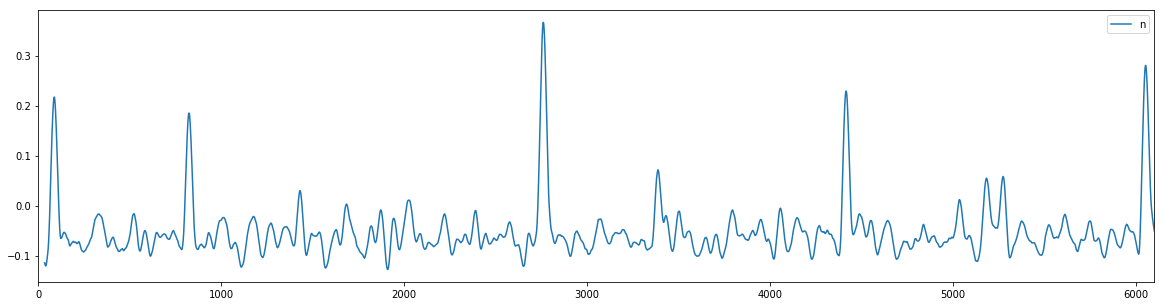

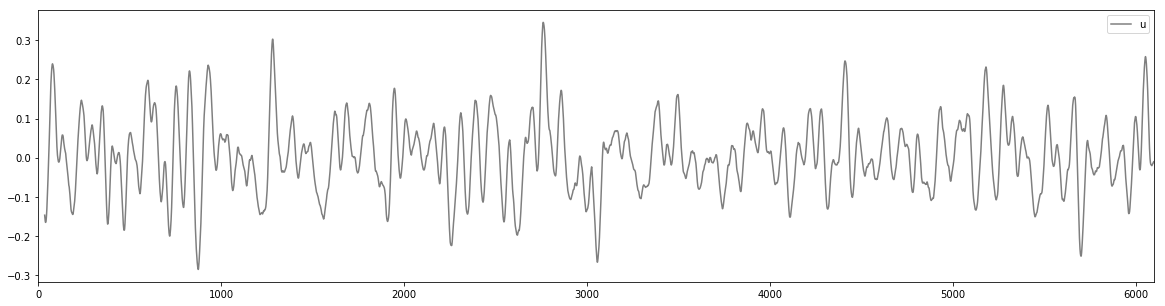

In [157]:


df_predict.plot( y="rolling", color='tab:orange',figsize=(20,5),label='e')
df_predictn.plot( y="rolling",figsize=(20,5),label='n')
df_predictu.plot(y='rolling',figsize=(20,5),label='u',color='tab:gray')

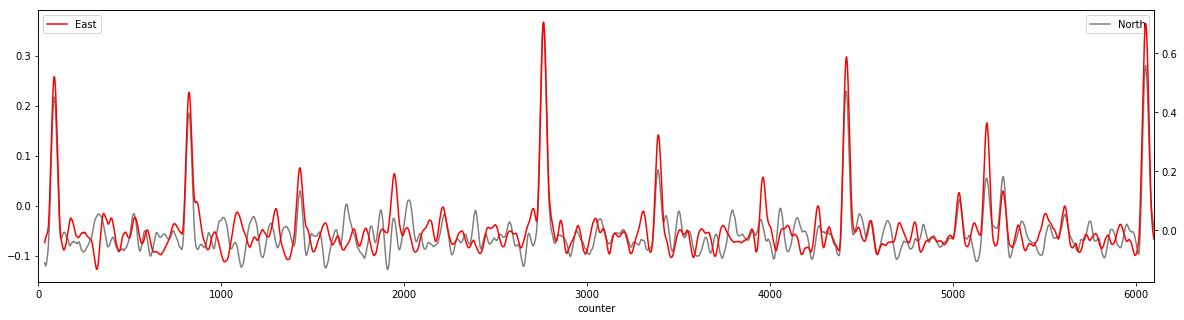

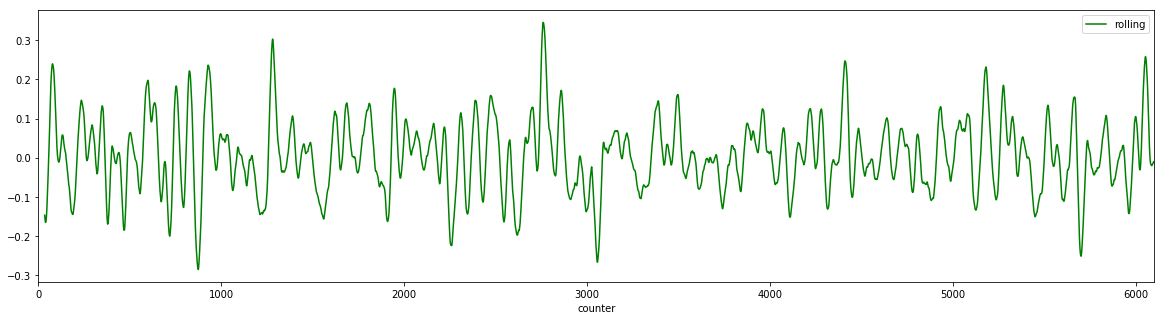

In [136]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

df_predictn.plot(x="counter", y=["rolling"], ax=ax,figsize=(20,5),color='gray')
df_predict.plot(x="counter", y=["rolling"], ax=ax2, color='red')

df_predictu.plot(x="counter", y=["rolling"], color='green',figsize=(20,5))

# df_e.plot(y=["e"],figsize=(20,5))

ax.legend(["North"], loc='upper right')
ax2.legend(["East"])

plt.show()

## Events tag

In [137]:
event_detail_1 = df_e.loc[(df_e.index >= '2010-03-01') & (df_e.index <= '2010-05-01')]


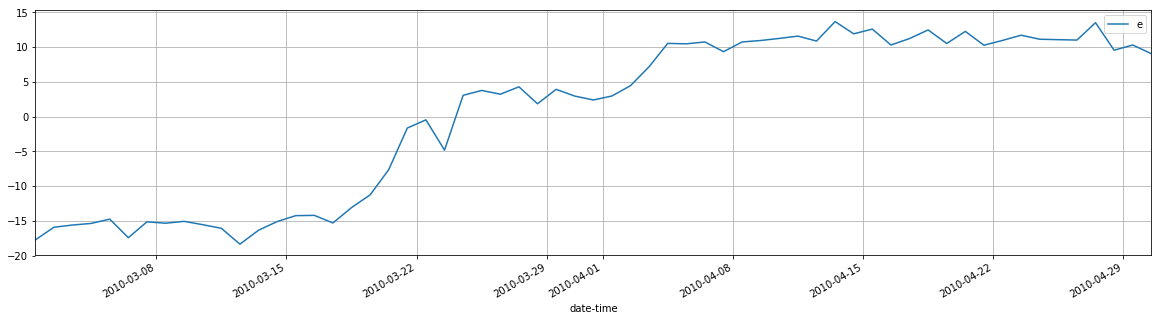

In [138]:
ax = event_detail_1.plot(y='e',figsize=(20,5),grid=True)


In [139]:
event_detail_2 = df_e.loc[(df_e.index >= '2014-09-01') & (df_e.index <= '2014-12-01')]

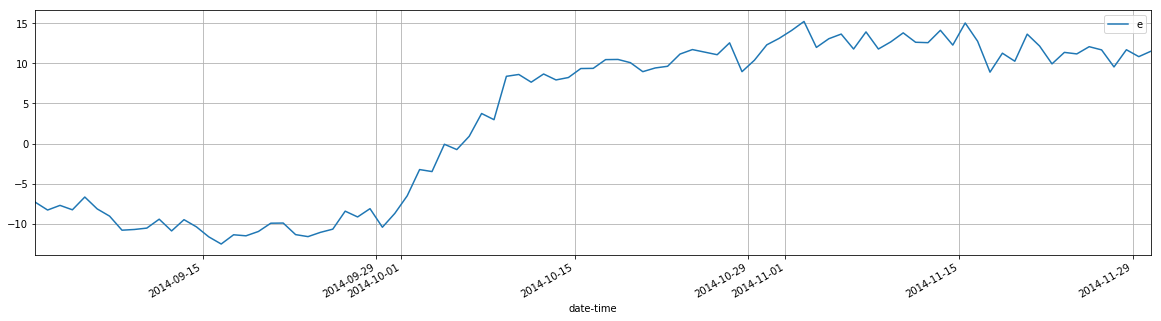

In [140]:
ax = event_detail_2.plot(y='e',figsize=(20,5),grid=True)

# Maximun determination

In [141]:
df['max'] = df_predict.e[(df_predict.e.shift(1) < df_predict.e) & (df_predict.e.shift(-1) < df_predict.e)]

AttributeError: 'DataFrame' object has no attribute 'e'